In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('data/llm_predictions.parquet')
df = df[df['model'] == 'qwen2.5:0.5b']
comments_df =pd.read_parquet('data/comments.parquet')
df = df.merge(
        comments_df[['id', 'rating', 'comment_length', 'pros_length_proportion', 'comment_length_group', 'pros_length_proportion_group']].rename(columns={'rating':'real_rating'}),
        on='id',
        how='inner'
    )
df['is_inconsistent'] = (
            (df['rating'] - df['real_rating'] > 1) |
            (df['rating'] - df['real_rating'] < -1)
            ).astype(int)

In [22]:
def select_llm_inconsistent_ids(model='qwen2.5:0.5b', llm_predictions_path='data/llm_predictions.parquet'):
    df = pd.read_parquet(llm_predictions_path)
    df = df[df['model'] == model]
    df = df.merge(
        comments_df[['id', 'rating']].rename(columns={'rating':'real_rating'}),
        on='id',
        how='inner'
    )
    df['is_inconsistent'] = (
                (df['rating'] - df['real_rating'] > 1) |
                (df['rating'] - df['real_rating'] < -1)
                )
    df = df[df['is_inconsistent'] == True]
    return set(df['id'])
inconsistent_ids = select_llm_inconsistent_ids()
print(inconsistent_ids)

{'63a9dd78242cd0d6b3401c5deba4599bc4c1a47c4de5bd9cb6e81b313b6c8d50', '7115bccd5476046abfa2ca38197872eee517b828cf481c17a2d77143bfc6cb2a', 'd1d04bc3425fe8b30c89e884ac023e885f2926971ef2e1ec972cfbb8e1db6687', 'f44d741950bd1b4618592771c938274a81addaea335879f3345982762b854401', 'e69dcbe3ed56cedfc8efef10fdc89fa15a86e169a279e470ffcc8c04cdfdb110', '43629f67b6b4e2500eb6a317fcdd30b5dc70a126bfea53963a351a12740f7917', '5db0ed1799fea888954f93bb405562ca2a82cf56f0019b3811aff5150c877528', '2c438183fee6ccea440a2f1f879b0dada9ca07e73ecda61aebe5c5d737f162cb', '1b3052df7af7d293557ab5b562940a4594b8bbbe1917e197eed92f5044966b5a', 'a0633ce87f84b5e5225fe5b339fffdd64b5cd00734d3e211758906dbe1039c27', '74afdd7d86a4df3018caad5d95fff8bdbf70b8b37ca34f3dbeca196f31d9ea4c', '58706e69f71cb576381826154a3f4fbbfccddd9149eac86823b1bcadd46927df', '2edf97720d0a0b666351785549a59f9f55a687abd82bdaab6e8970d4e437dc31', 'c272948495d3aca8319ed684f40f774c39bccf0396211ee19692135d17860586', '705bdcc993ee02fae416dc72ebaedfd5c685806738f664

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57272 entries, 0 to 57271
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            57272 non-null  object        
 1   model                         57272 non-null  object        
 2   rating                        57272 non-null  int64         
 3   prediction_time               57272 non-null  float64       
 4   ts_prediction                 57272 non-null  datetime64[ns]
 5   extra_info                    57272 non-null  object        
 6   processing_time               57272 non-null  float64       
 7   real_rating                   57272 non-null  int64         
 8   comment_length                57272 non-null  int64         
 9   pros_length_proportion        57272 non-null  int64         
 10  comment_length_group          57272 non-null  int64         
 11  pros_length_proportion_group

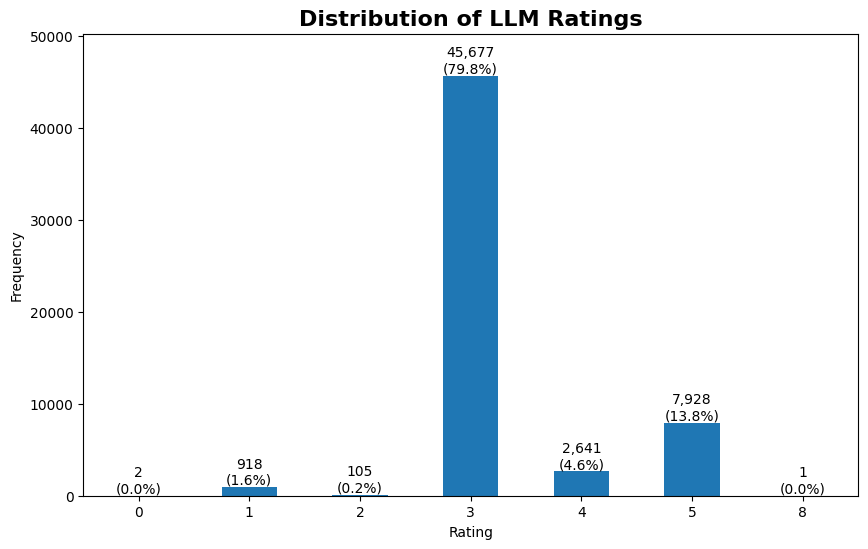

In [14]:
rating_counts = df['rating'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of LLM Ratings', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

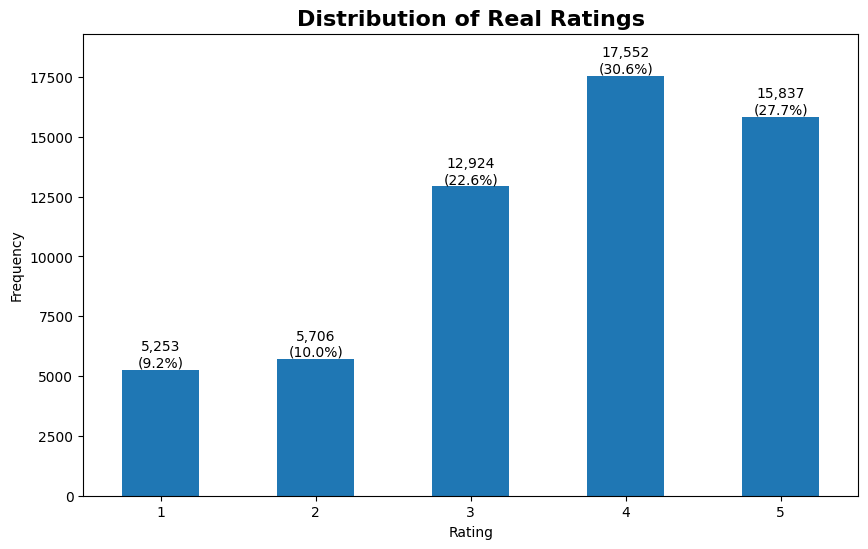

In [4]:
real_rating_counts = df['real_rating'].value_counts().sort_index()
total = real_rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = real_rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Real Ratings', fontsize=16, fontweight='bold')
ax.set_ylim(0, real_rating_counts.max() * 1.1)

for i, count in enumerate(real_rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

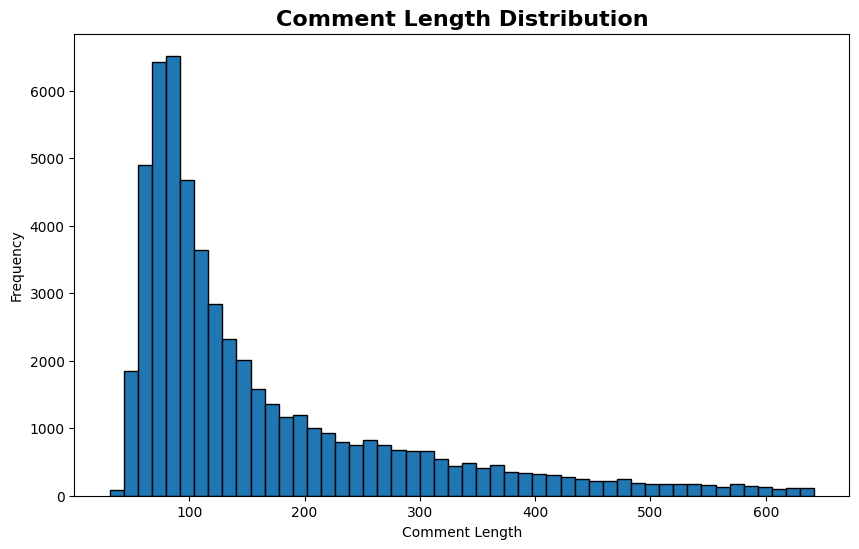

In [5]:
max_length = df['comment_length'].quantile(0.95)
filtered = df[df['comment_length'] <= max_length]

plt.figure(figsize=(10,6))
plt.hist(filtered['comment_length'], bins=50, edgecolor='black')
plt.title('Comment Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

In [6]:
percentiles = df['comment_length'].quantile([0.2, 0.4, 0.6, 0.8]).reset_index()
percentiles.columns = ['Percentile', 'Comment Length']
display(percentiles)


,Percentile,Comment Length
0,0.2,76.0
1,0.4,100.0
2,0.6,147.0
3,0.8,279.0


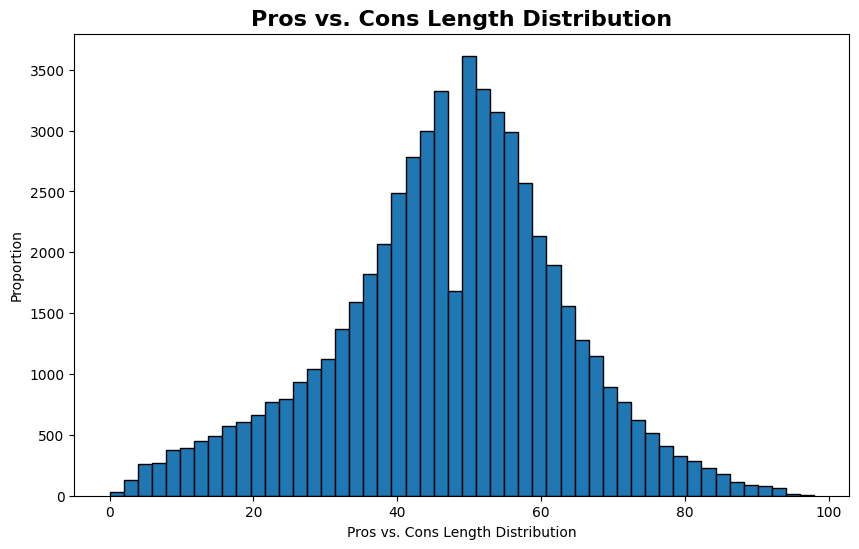

In [7]:
plt.figure(figsize=(10,6))
plt.hist(df['pros_length_proportion'], bins=50, edgecolor='black')
plt.title('Pros vs. Cons Length Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Pros vs. Cons Length Distribution')
plt.ylabel('Proportion')
plt.show()

In [8]:
percentiles = df['pros_length_proportion'].quantile([0.2, 0.4, 0.6, 0.8]).reset_index()
percentiles.columns = ['Percentile', 'Pros vs. Cons Length Distribution']
display(percentiles)


,Percentile,Pros vs. Cons Length Distribution
0,0.2,35.0
1,0.4,45.0
2,0.6,52.0
3,0.8,60.0


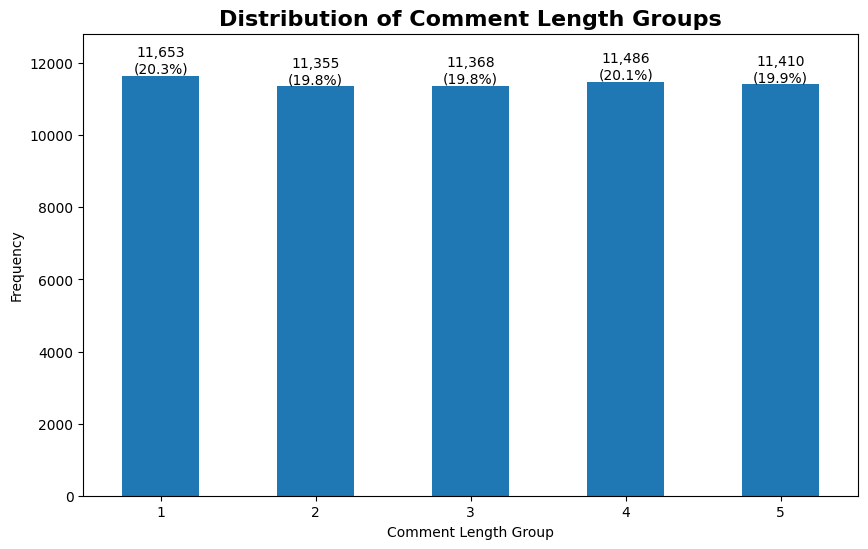

In [9]:
rating_counts = df['comment_length_group'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Comment Length Group')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Length Groups', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

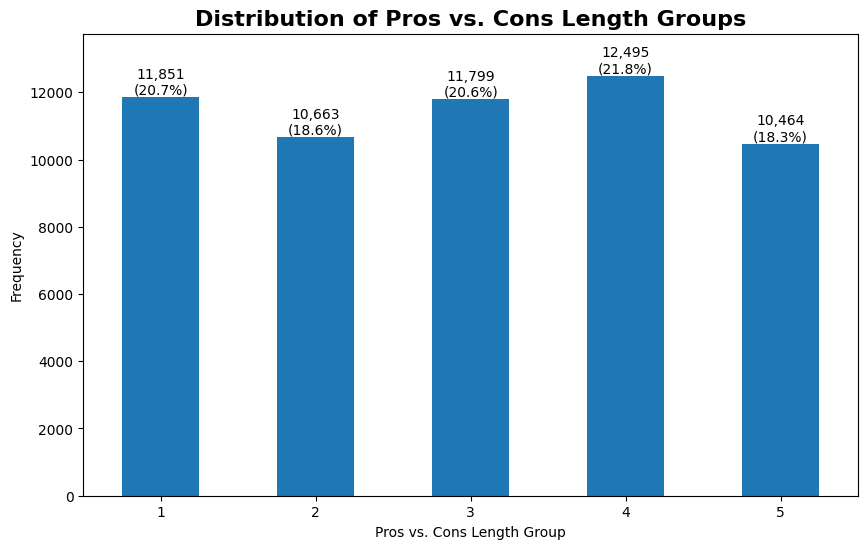

In [10]:
rating_counts = df['pros_length_proportion_group'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Pros vs. Cons Length Group')
plt.ylabel('Frequency')
plt.title('Distribution of Pros vs. Cons Length Groups', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [11]:
cross_tab = pd.crosstab(df['comment_length_group'], df['pros_length_proportion_group'])
print(cross_tab)

pros_length_proportion_group     1     2     3     4     5
comment_length_group                                      
1                              403  2305  3570  3948  1427
2                              910  2492  2917  3043  1993
3                             2050  2317  2108  2323  2570
4                             3293  1941  1811  1843  2598
5                             5195  1608  1393  1338  1876


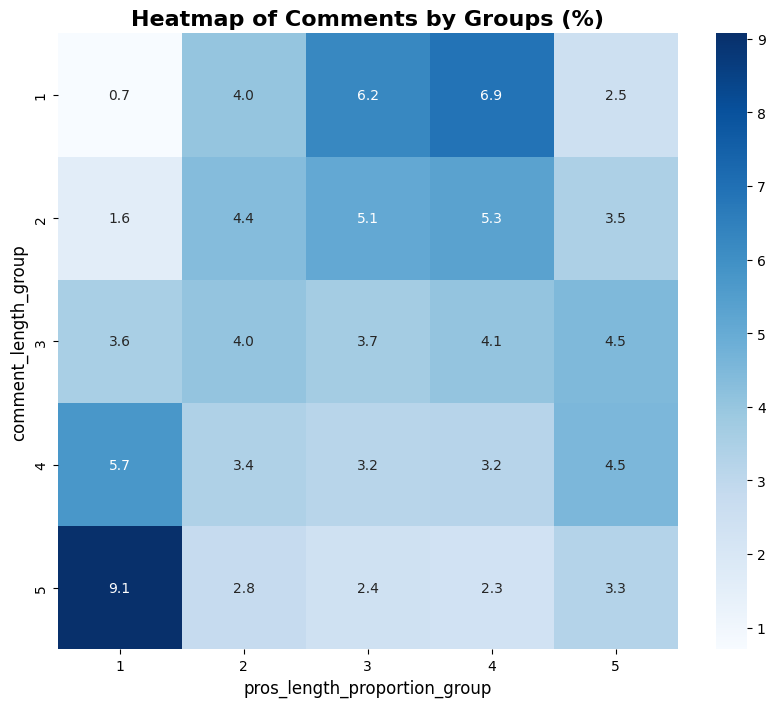

In [12]:
cross_tab = pd.crosstab(df['comment_length_group'], df['pros_length_proportion_group'])

# Calcula o total de comentários e converte as contagens em porcentagens
total_comments = cross_tab.values.sum()
cross_tab_percent = (cross_tab / total_comments) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab_percent, annot=True, fmt=".1f", cmap="Blues")
plt.title("Heatmap of Comments by Groups (%)", fontsize=16, fontweight="bold")
plt.xlabel("pros_length_proportion_group", fontsize=12)
plt.ylabel("comment_length_group", fontsize=12)
plt.show()

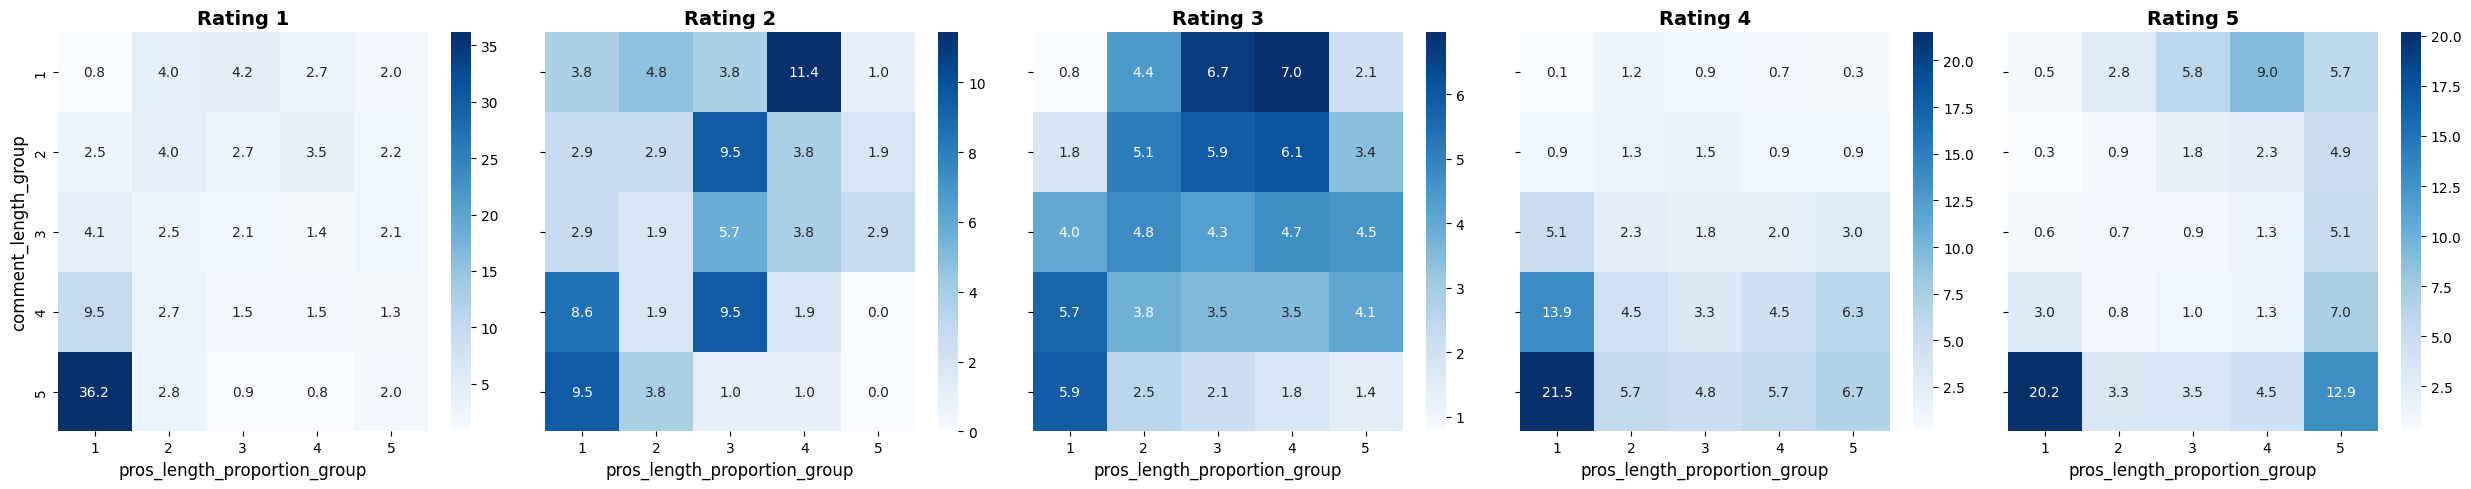

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

for rating in range(1, 6):
    # Filtra o DataFrame para o rating atual
    df_filtered = df[df['rating'] == rating]
    
    # Cria uma tabela cruzada com as contagens
    cross_tab = pd.crosstab(df_filtered['comment_length_group'], df_filtered['pros_length_proportion_group'])
    
    # Calcula o total de comentários para o rating filtrado
    total_comments = cross_tab.values.sum()
    
    # Converte as contagens em porcentagens (se houver comentários)
    if total_comments > 0:
        cross_tab_percent = (cross_tab / total_comments) * 100
    else:
        cross_tab_percent = cross_tab.copy()
    
    # Gera o heatmap no subplot correspondente
    sns.heatmap(cross_tab_percent, annot=True, fmt=".1f", cmap="Blues", ax=axes[rating-1])
    axes[rating-1].set_title(f'Rating {rating}', fontsize=14, fontweight='bold')
    axes[rating-1].set_xlabel("pros_length_proportion_group", fontsize=12)
    if rating == 1:
        axes[rating-1].set_ylabel("comment_length_group", fontsize=12)
    else:
        axes[rating-1].set_ylabel("")

plt.tight_layout()

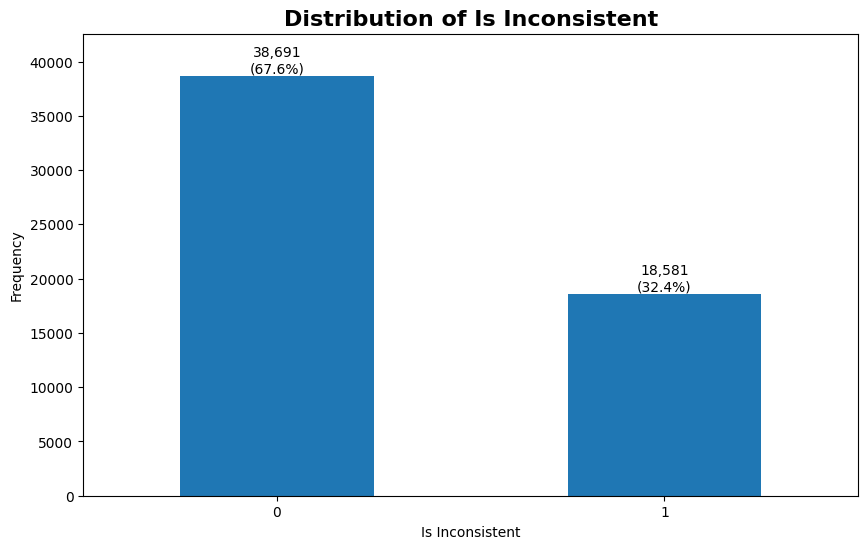

In [20]:
rating_counts = df['is_inconsistent'].value_counts().sort_index()
total = rating_counts.sum()

plt.figure(figsize=(10, 6),)
ax = rating_counts.plot(kind='bar')
plt.xlabel('Is Inconsistent')
plt.ylabel('Frequency')
plt.title('Distribution of Is Inconsistent', fontsize=16, fontweight='bold')
ax.set_ylim(0, rating_counts.max() * 1.1)

for i, count in enumerate(rating_counts):
    percentage = (count / total) * 100
    ax.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()